# MovieLens 100K Recommender System - Phase 2
## Collaborative Filtering (Memory-Based)

**Project:** Hybrid Movie Recommendation System  
**Dataset:** MovieLens 100K  
**Author:** Harpinder Singh  
**Date:** December 2025  
**Baseline RMSE to Beat:** 1.0210

## ╔═══════════════════════════════════════════════════════════╗
## ║                    IMPORTS & SETUP                        ║
## ╚═══════════════════════════════════════════════════════════╝

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Surprise library for collaborative filtering
from surprise import Dataset, Reader, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

warnings.filterwarnings('ignore')
np.random.seed(42)

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")
print(f"📅 Execution Date: {datetime.now().strftime('%B %d, %Y')}")

✅ Libraries imported successfully
📅 Execution Date: January 31, 2026


## ╔═══════════════════════════════════════════════════════════╗
## ║                  LOAD MERGED DATASET                      ║
## ╚═══════════════════════════════════════════════════════════╝

In [2]:
# ┌─────────────────────────────────────────┐
# │ Load Data from Phase 1                  │
# └─────────────────────────────────────────┘

data = pd.read_csv('../data/movielens_100k_merged.csv')

print("📊 Dataset Loaded:")
print(f"   Shape: {data.shape}")
print(f"   Columns: {list(data.columns)}")
print("\nFirst 5 rows:")
print(data.head())

📊 Dataset Loaded:
   Shape: (100000, 10)
   Columns: ['user_id', 'item_id', 'rating', 'timestamp', 'title', 'genres', 'age', 'gender', 'occupation', 'zip_code']

First 5 rows:
   user_id  item_id  rating  timestamp                       title  \
0      196      242       3  881250949                Kolya (1996)   
1      186      302       3  891717742    L.A. Confidential (1997)   
2       22      377       1  878887116         Heavyweights (1994)   
3      244       51       2  880606923  Legends of the Fall (1994)   
4      166      346       1  886397596         Jackie Brown (1997)   

                             genres  age gender  occupation zip_code  
0                            Comedy   49      M      writer    55105  
1  Crime|Film-Noir|Mystery|Thriller   39      F   executive    00000  
2                   Children|Comedy   25      M      writer    40206  
3         Drama|Romance|War|Western   28      M  technician    80525  
4                       Crime|Drama   47      M 

In [4]:
# ┌─────────────────────────────────────────┐
# │ Load Baseline Results                   │
# └─────────────────────────────────────────┘

baseline_results = pd.read_csv('../results/baseline_results.csv')

print("\n📊 Baseline Performance (Phase 1):")
print(baseline_results.to_string(index=False))
print(f"\n🎯 Target to Beat: RMSE < {baseline_results['RMSE'].min():.4f}")


📊 Baseline Performance (Phase 1):
           Model     RMSE      MAE
          Random 1.888160 1.514850
  Global Average 1.123860 0.941955
Popularity-Based 1.020964 0.812273

🎯 Target to Beat: RMSE < 1.0210


## ╔═══════════════════════════════════════════════════════════╗
## ║              PREPARE DATA FOR SURPRISE                    ║
## ╚═══════════════════════════════════════════════════════════╝

In [5]:
# ┌─────────────────────────────────────────┐
# │ Create Surprise Dataset                 │
# └─────────────────────────────────────────┘

# Define rating scale (1-5)
reader = Reader(rating_scale=(1, 5))

# Load data into Surprise format
surprise_data = Dataset.load_from_df(
    data[['user_id', 'item_id', 'rating']], 
    reader
)

# Train-test split (80-20)
trainset, testset = train_test_split(surprise_data, test_size=0.2, random_state=42)

print("📊 Data Prepared for Surprise:")
print(f"   Training samples: {trainset.n_ratings:,}")
print(f"   Test samples:     {len(testset):,}")
print(f"   Users:            {trainset.n_users:,}")
print(f"   Items:            {trainset.n_items:,}")

📊 Data Prepared for Surprise:
   Training samples: 80,000
   Test samples:     20,000
   Users:            943
   Items:            1,651


## ╔═══════════════════════════════════════════════════════════╗
## ║          USER-BASED COLLABORATIVE FILTERING               ║
## ╚═══════════════════════════════════════════════════════════╝

In [6]:
# ┌─────────────────────────────────────────┐
# │ User-Based CF (Basic)                   │
# └─────────────────────────────────────────┘

print("👥 USER-BASED COLLABORATIVE FILTERING (Basic)")
print("=" * 60)

# Configure user-based similarity
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# Train model
user_based_basic = KNNBasic(sim_options=sim_options, verbose=False)
user_based_basic.fit(trainset)

# Predict on test set
predictions_ub_basic = user_based_basic.test(testset)

# Calculate metrics
rmse_ub_basic = accuracy.rmse(predictions_ub_basic, verbose=False)
mae_ub_basic = accuracy.mae(predictions_ub_basic, verbose=False)

print(f"RMSE: {rmse_ub_basic:.4f}")
print(f"MAE:  {mae_ub_basic:.4f}")
print(f"\nImprovement over baseline: {((baseline_results['RMSE'].min() - rmse_ub_basic) / baseline_results['RMSE'].min() * 100):.2f}%")

👥 USER-BASED COLLABORATIVE FILTERING (Basic)
RMSE: 1.0194
MAE:  0.8038

Improvement over baseline: 0.16%


In [7]:
# ┌─────────────────────────────────────────┐
# │ User-Based CF (With Means)              │
# └─────────────────────────────────────────┘

print("\n👥 USER-BASED COLLABORATIVE FILTERING (With Means)")
print("=" * 60)

# Configure user-based similarity with mean normalization
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# Train model
user_based_means = KNNWithMeans(sim_options=sim_options, verbose=False)
user_based_means.fit(trainset)

# Predict on test set
predictions_ub_means = user_based_means.test(testset)

# Calculate metrics
rmse_ub_means = accuracy.rmse(predictions_ub_means, verbose=False)
mae_ub_means = accuracy.mae(predictions_ub_means, verbose=False)

print(f"RMSE: {rmse_ub_means:.4f}")
print(f"MAE:  {mae_ub_means:.4f}")
print(f"\nImprovement over baseline: {((baseline_results['RMSE'].min() - rmse_ub_means) / baseline_results['RMSE'].min() * 100):.2f}%")


👥 USER-BASED COLLABORATIVE FILTERING (With Means)
RMSE: 0.9538
MAE:  0.7526

Improvement over baseline: 6.57%


In [8]:
# ┌─────────────────────────────────────────┐
# │ User-Based CF (Z-Score Normalization)   │
# └─────────────────────────────────────────┘

print("\n👥 USER-BASED COLLABORATIVE FILTERING (Z-Score)")
print("=" * 60)

# Configure user-based similarity with z-score normalization
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# Train model
user_based_zscore = KNNWithZScore(sim_options=sim_options, verbose=False)
user_based_zscore.fit(trainset)

# Predict on test set
predictions_ub_zscore = user_based_zscore.test(testset)

# Calculate metrics
rmse_ub_zscore = accuracy.rmse(predictions_ub_zscore, verbose=False)
mae_ub_zscore = accuracy.mae(predictions_ub_zscore, verbose=False)

print(f"RMSE: {rmse_ub_zscore:.4f}")
print(f"MAE:  {mae_ub_zscore:.4f}")
print(f"\nImprovement over baseline: {((baseline_results['RMSE'].min() - rmse_ub_zscore) / baseline_results['RMSE'].min() * 100):.2f}%")


👥 USER-BASED COLLABORATIVE FILTERING (Z-Score)
RMSE: 0.9544
MAE:  0.7506

Improvement over baseline: 6.52%


## ╔═══════════════════════════════════════════════════════════╗
## ║          ITEM-BASED COLLABORATIVE FILTERING               ║
## ╚═══════════════════════════════════════════════════════════╝

In [9]:
# ┌─────────────────────────────────────────┐
# │ Item-Based CF (Basic)                   │
# └─────────────────────────────────────────┘

print("\n🎬 ITEM-BASED COLLABORATIVE FILTERING (Basic)")
print("=" * 60)

# Configure item-based similarity
sim_options = {
    'name': 'cosine',
    'user_based': False  # Item-based
}

# Train model
item_based_basic = KNNBasic(sim_options=sim_options, verbose=False)
item_based_basic.fit(trainset)

# Predict on test set
predictions_ib_basic = item_based_basic.test(testset)

# Calculate metrics
rmse_ib_basic = accuracy.rmse(predictions_ib_basic, verbose=False)
mae_ib_basic = accuracy.mae(predictions_ib_basic, verbose=False)

print(f"RMSE: {rmse_ib_basic:.4f}")
print(f"MAE:  {mae_ib_basic:.4f}")
print(f"\nImprovement over baseline: {((baseline_results['RMSE'].min() - rmse_ib_basic) / baseline_results['RMSE'].min() * 100):.2f}%")


🎬 ITEM-BASED COLLABORATIVE FILTERING (Basic)
RMSE: 1.0264
MAE:  0.8104

Improvement over baseline: -0.54%


In [10]:
# ┌─────────────────────────────────────────┐
# │ Item-Based CF (With Means)              │
# └─────────────────────────────────────────┘

print("\n🎬 ITEM-BASED COLLABORATIVE FILTERING (With Means)")
print("=" * 60)

# Configure item-based similarity with mean normalization
sim_options = {
    'name': 'cosine',
    'user_based': False  # Item-based
}

# Train model
item_based_means = KNNWithMeans(sim_options=sim_options, verbose=False)
item_based_means.fit(trainset)

# Predict on test set
predictions_ib_means = item_based_means.test(testset)

# Calculate metrics
rmse_ib_means = accuracy.rmse(predictions_ib_means, verbose=False)
mae_ib_means = accuracy.mae(predictions_ib_means, verbose=False)

print(f"RMSE: {rmse_ib_means:.4f}")
print(f"MAE:  {mae_ib_means:.4f}")
print(f"\nImprovement over baseline: {((baseline_results['RMSE'].min() - rmse_ib_means) / baseline_results['RMSE'].min() * 100):.2f}%")


🎬 ITEM-BASED COLLABORATIVE FILTERING (With Means)
RMSE: 0.9402
MAE:  0.7399

Improvement over baseline: 7.91%


In [11]:
# ┌─────────────────────────────────────────┐
# │ Item-Based CF (Z-Score Normalization)   │
# └─────────────────────────────────────────┘

print("\n🎬 ITEM-BASED COLLABORATIVE FILTERING (Z-Score)")
print("=" * 60)

# Configure item-based similarity with z-score normalization
sim_options = {
    'name': 'cosine',
    'user_based': False  # Item-based
}

# Train model
item_based_zscore = KNNWithZScore(sim_options=sim_options, verbose=False)
item_based_zscore.fit(trainset)

# Predict on test set
predictions_ib_zscore = item_based_zscore.test(testset)

# Calculate metrics
rmse_ib_zscore = accuracy.rmse(predictions_ib_zscore, verbose=False)
mae_ib_zscore = accuracy.mae(predictions_ib_zscore, verbose=False)

print(f"RMSE: {rmse_ib_zscore:.4f}")
print(f"MAE:  {mae_ib_zscore:.4f}")
print(f"\nImprovement over baseline: {((baseline_results['RMSE'].min() - rmse_ib_zscore) / baseline_results['RMSE'].min() * 100):.2f}%")


🎬 ITEM-BASED COLLABORATIVE FILTERING (Z-Score)
RMSE: 0.9423
MAE:  0.7405

Improvement over baseline: 7.70%


## ╔═══════════════════════════════════════════════════════════╗
## ║              COMPARE ALL CF MODELS                        ║
## ╚═══════════════════════════════════════════════════════════╝

In [13]:
# ┌─────────────────────────────────────────┐
# │ Compile All Results                     │
# └─────────────────────────────────────────┘

cf_results = pd.DataFrame({
    'Model': [
        'Baseline (Popularity)',
        'User-Based CF (Basic)',
        'User-Based CF (Means)',
        'User-Based CF (Z-Score)',
        'Item-Based CF (Basic)',
        'Item-Based CF (Means)',
        'Item-Based CF (Z-Score)'
    ],
    'RMSE': [
        baseline_results['RMSE'].min(),
        rmse_ub_basic,
        rmse_ub_means,
        rmse_ub_zscore,
        rmse_ib_basic,
        rmse_ib_means,
        rmse_ib_zscore
    ],
    'MAE': [
        baseline_results.loc[baseline_results['RMSE'].idxmin(), 'MAE'],
        mae_ub_basic,
        mae_ub_means,
        mae_ub_zscore,
        mae_ib_basic,
        mae_ib_means,
        mae_ib_zscore
    ]
})

# Sort by RMSE
cf_results = cf_results.sort_values('RMSE').reset_index(drop=True)

print("\n📊 COLLABORATIVE FILTERING RESULTS")
print("=" * 70)
print(cf_results.to_string(index=False))

# Save results
cf_results.to_csv('../results/cf_results.csv', index=False)
print("\n💾 Results saved to: cf_results.csv")


📊 COLLABORATIVE FILTERING RESULTS
                  Model     RMSE      MAE
  Item-Based CF (Means) 0.940247 0.739867
Item-Based CF (Z-Score) 0.942329 0.740470
  User-Based CF (Means) 0.953842 0.752562
User-Based CF (Z-Score) 0.954422 0.750558
  User-Based CF (Basic) 1.019354 0.803799
  Baseline (Popularity) 1.020964 0.812273
  Item-Based CF (Basic) 1.026430 0.810381

💾 Results saved to: cf_results.csv


In [15]:
# ┌─────────────────────────────────────────┐
# │ Best Model Identification               │
# └─────────────────────────────────────────┘

best_model_idx = cf_results['RMSE'].idxmin()
best_model_name = cf_results.loc[best_model_idx, 'Model']
best_rmse = cf_results.loc[best_model_idx, 'RMSE']
best_mae = cf_results.loc[best_model_idx, 'MAE']

baseline_rmse = baseline_results['RMSE'].min()
improvement = ((baseline_rmse - best_rmse) / baseline_rmse) * 100

print(f"\n🏆 BEST MODEL: {best_model_name}")
print("=" * 70)
print(f"   RMSE:                    {best_rmse:.4f}")
print(f"   MAE:                     {best_mae:.4f}")
print(f"   Baseline RMSE:           {baseline_rmse:.4f}")
print(f"   Improvement:             {improvement:.2f}%")


🏆 BEST MODEL: Item-Based CF (Means)
   RMSE:                    0.9402
   MAE:                     0.7399
   Baseline RMSE:           1.0210
   Improvement:             7.91%


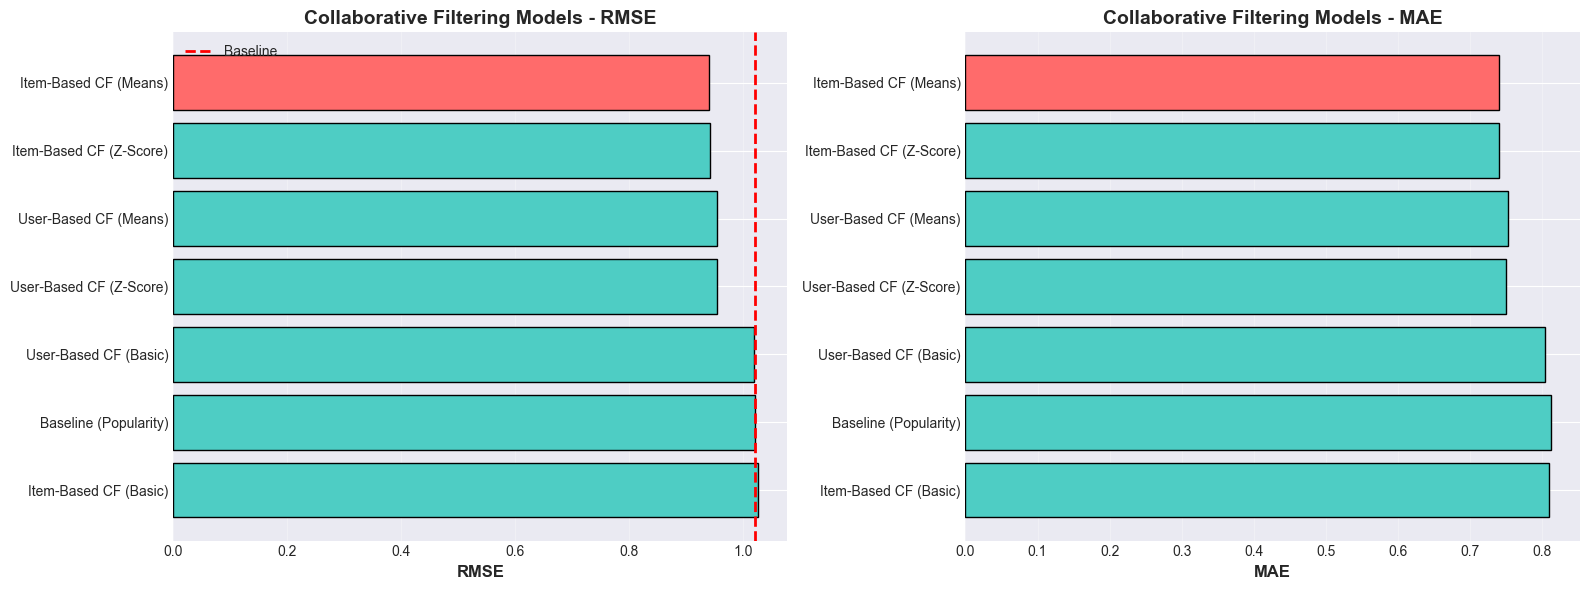

In [16]:
# ┌─────────────────────────────────────────┐
# │ Visualize Model Comparison              │
# └─────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
colors = ['#FF6B6B' if i == 0 else '#4ECDC4' for i in range(len(cf_results))]
axes[0].barh(cf_results['Model'], cf_results['RMSE'], color=colors, edgecolor='black')
axes[0].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('Collaborative Filtering Models - RMSE', fontsize=14, fontweight='bold')
axes[0].axvline(baseline_rmse, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# MAE comparison
axes[1].barh(cf_results['Model'], cf_results['MAE'], color=colors, edgecolor='black')
axes[1].set_xlabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Collaborative Filtering Models - MAE', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../results/visualizations/07_cf_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

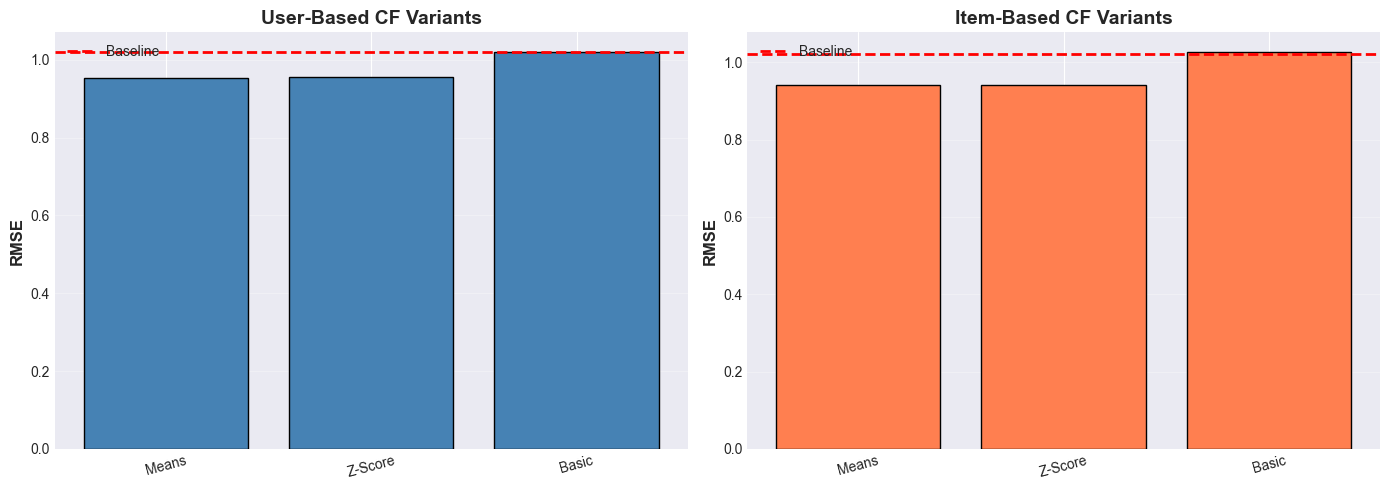

In [17]:
# ┌─────────────────────────────────────────┐
# │ User-Based vs Item-Based Comparison     │
# └─────────────────────────────────────────┘

# Separate user-based and item-based results
ub_results = cf_results[cf_results['Model'].str.contains('User-Based')].copy()
ib_results = cf_results[cf_results['Model'].str.contains('Item-Based')].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# User-Based comparison
ub_models = [m.split(' (')[1].replace(')', '') for m in ub_results['Model']]
axes[0].bar(ub_models, ub_results['RMSE'].values, color='steelblue', edgecolor='black')
axes[0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('User-Based CF Variants', fontsize=14, fontweight='bold')
axes[0].axhline(baseline_rmse, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=15)

# Item-Based comparison
ib_models = [m.split(' (')[1].replace(')', '') for m in ib_results['Model']]
axes[1].bar(ib_models, ib_results['RMSE'].values, color='coral', edgecolor='black')
axes[1].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[1].set_title('Item-Based CF Variants', fontsize=14, fontweight='bold')
axes[1].axhline(baseline_rmse, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('../results/visualizations/08_ub_vs_ib_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## ╔═══════════════════════════════════════════════════════════╗
## ║            SAMPLE RECOMMENDATIONS DEMO                    ║
## ╚═══════════════════════════════════════════════════════════╝

In [18]:
# ┌─────────────────────────────────────────┐
# │ Select Best Model for Demo              │
# └─────────────────────────────────────────┘

# Use the best performing model from above
# Map model name to actual model object
model_mapping = {
    'User-Based CF (Basic)': user_based_basic,
    'User-Based CF (Means)': user_based_means,
    'User-Based CF (Z-Score)': user_based_zscore,
    'Item-Based CF (Basic)': item_based_basic,
    'Item-Based CF (Means)': item_based_means,
    'Item-Based CF (Z-Score)': item_based_zscore
}

best_cf_model = model_mapping[best_model_name]
print(f"🎯 Using {best_model_name} for recommendations demo")

🎯 Using Item-Based CF (Means) for recommendations demo


In [19]:
# ┌─────────────────────────────────────────┐
# │ Get Top-N Recommendations Function      │
# └─────────────────────────────────────────┘

def get_top_n_recommendations(model, user_id, n=10, trainset=trainset):
    """
    Get top N movie recommendations for a user.
    
    Parameters
    ----------
    model : Surprise model
        Trained collaborative filtering model
    user_id : int
        User ID to get recommendations for
    n : int
        Number of recommendations
    trainset : Trainset
        Surprise trainset object
    
    Returns
    -------
    list
        List of (item_id, predicted_rating) tuples
    """
    # Get all items
    all_items = trainset.all_items()
    
    # Get items already rated by user
    user_items = set([j for (j, _) in trainset.ur[trainset.to_inner_uid(user_id)]])
    
    # Get items not rated by user
    items_to_predict = [trainset.to_raw_iid(i) for i in all_items if i not in user_items]
    
    # Predict ratings for all unrated items
    predictions = [model.predict(user_id, item_id) for item_id in items_to_predict]
    
    # Sort by predicted rating
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Return top N
    return [(pred.iid, pred.est) for pred in predictions[:n]]

print("✅ Recommendation function defined")

✅ Recommendation function defined


In [20]:
# ┌─────────────────────────────────────────┐
# │ Generate Sample Recommendations         │
# └─────────────────────────────────────────┘

# Select random user for demo
sample_user_id = 196

print(f"\n🎬 TOP 10 RECOMMENDATIONS FOR USER {sample_user_id}")
print("=" * 70)

# Get recommendations
recommendations = get_top_n_recommendations(best_cf_model, sample_user_id, n=10)

# Map to movie titles
movie_titles = data[['item_id', 'title', 'genres']].drop_duplicates()

rec_df = pd.DataFrame(recommendations, columns=['item_id', 'predicted_rating'])
rec_df = rec_df.merge(movie_titles, on='item_id', how='left')
rec_df['rank'] = range(1, len(rec_df) + 1)

print(rec_df[['rank', 'title', 'genres', 'predicted_rating']].to_string(index=False))

# Show user's actual ratings for context
print(f"\n📊 USER {sample_user_id}'S ACTUAL RATINGS (Sample):")
print("=" * 70)
user_ratings = data[data['user_id'] == sample_user_id][['title', 'rating', 'genres']].head(10)
print(user_ratings.to_string(index=False))


🎬 TOP 10 RECOMMENDATIONS FOR USER 196
 rank                                      title      genres  predicted_rating
    1                         Prefontaine (1997)       Drama          5.000000
    2             They Made Me a Criminal (1939) Crime|Drama          5.000000
    3       Saint of Fort Washington, The (1993)       Drama          5.000000
    4              Someone Else's America (1995)       Drama          5.000000
    5              Great Day in Harlem, A (1994) Documentary          5.000000
    6                       Aiqing wansui (1994)       Drama          5.000000
    7                  Santa with Muscles (1996)      Comedy          5.000000
    8 Marlene Dietrich: Shadow and Light (1996)  Documentary          4.863749
    9     World of Apu, The (Apur Sansar) (1959)       Drama          4.696024
   10     Maya Lin: A Strong Clear Vision (1994) Documentary          4.669878

📊 USER 196'S ACTUAL RATINGS (Sample):
                                      title  rating  

## ╔═══════════════════════════════════════════════════════════╗
## ║                  PHASE 2 SUMMARY                          ║
## ╚═══════════════════════════════════════════════════════════╝

In [21]:
print("="*70)
print("                 PHASE 2 COMPLETE ✅")
print("="*70)
print("\n📦 DELIVERABLES:")
print("   ✅ 6 Collaborative Filtering models trained")
print("   ✅ 3 User-Based CF variants (Basic, Means, Z-Score)")
print("   ✅ 3 Item-Based CF variants (Basic, Means, Z-Score)")
print("   ✅ 2 visualizations saved (07-08.png)")
print("   ✅ CF results saved (cf_results.csv)")
print("   ✅ Sample recommendations generated")

print("\n📊 KEY RESULTS:")
print(f"   • Best Model:            {best_model_name}")
print(f"   • Best RMSE:             {best_rmse:.4f}")
print(f"   • Baseline RMSE:         {baseline_rmse:.4f}")
print(f"   • Improvement:           {improvement:.2f}%")

print("\n🎯 NEXT STEPS:")
print("   → Phase 3: Matrix Factorization (SVD, ALS)")
print("   → Goal: Further improve RMSE beyond {:.4f}".format(best_rmse))
print("\n" + "="*70)

                 PHASE 2 COMPLETE ✅

📦 DELIVERABLES:
   ✅ 6 Collaborative Filtering models trained
   ✅ 3 User-Based CF variants (Basic, Means, Z-Score)
   ✅ 3 Item-Based CF variants (Basic, Means, Z-Score)
   ✅ 2 visualizations saved (07-08.png)
   ✅ CF results saved (cf_results.csv)
   ✅ Sample recommendations generated

📊 KEY RESULTS:
   • Best Model:            Item-Based CF (Means)
   • Best RMSE:             0.9402
   • Baseline RMSE:         1.0210
   • Improvement:           7.91%

🎯 NEXT STEPS:
   → Phase 3: Matrix Factorization (SVD, ALS)
   → Goal: Further improve RMSE beyond 0.9402

